# Normal toy example
We aim to test the feasability of using gradient boosted machines in regression in order to boost the basuc ABC rejection algorithm. The idea of the experiment originates from: https://arxiv.org/abs/1605.05537

## Arguments:
* No effort put into choosnig relevant summary statistic
* No need to tune a $\varepsilon$ parameter for the rejection

## Procedure
1. Construct reference table T_data with N data
    * Normal example:
    \begin{equation}
        y_i \sim \mathcal{N}(\theta_1, \theta_2), \theta_2 > 0
    \end{equation}
    
    * Normal toy example:
    \begin{equation}
        \begin{aligned}
            y_i | \theta_1, \theta_2 &\sim \mathcal{N}(\theta_1, \theta_2), \\
            \theta_1 | \theta_2 &\sim \mathcal{N}(0, \theta_2), \\
            \theta_2 &\sim \mathcal{IG}(4,3)
        \end{aligned}
    \end{equation}
2. Construct reference table T_ss from summary statistics of T_data
    * Use tsfresh
3. Split T_ss into training, T_ss_train (70%), and testing dataset, T_ss_test (30%)
    * sklearn train_test_split
4. Train a GBM to estimate each parameter using T_ss_train
    * catboost?
5. Evaluate the GBM on T_ss_test

## 1. Construct the reference table


In [1]:
from scipy.stats import invgamma, norm, uniform
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def gen_y(shape=4, scale=3, size_y = 10):
    '''Generates samples from the hierachical Normal mean model.
    
    Parameters:
    shape (int): the shape paramter in the IG distribution
    scale (int): the scale paramter in the IG distribution
    size_y (int): the number of samples per parameter pair.
    
    Returns:
    dict of lists: theta_1 (int), theta_2 (int), y (list) 
    '''
    
    # generate theta_2
    theta_2 = invgamma.rvs(a=shape, scale=scale, size=1)
    
    # generate theta_1
    theta_1 = norm.rvs(loc=0, scale=theta_2, size=1)
    
    # generate y
    y = norm.rvs(loc=theta_1, scale=theta_2, size=size_y)
    return({"y":y,"theta_1": theta_1, "theta_2": theta_2})

In [3]:
def gen_y_norm(theta_1=0, theta_2=1, size_y=10):
    y = norm.rvs(loc=theta_1, scale=theta_2, size=size_y)
    return(y)

In [4]:
def gen_y_norm_reftable(size_y, N_data=10000):
    '''
    Generate N_data samples from gen_norm
    '''
    y_out = np.zeros(N_data*size_y)
    params = np.zeros((N_data,2))
    for i in range(N_data):
        # sample from prior
        theta_1 = uniform.rvs(-10,20)
        theta_2 = uniform.rvs(0,10)
        
        params[i,0] = theta_1
        params[i,1] = theta_2

        # simulate from model
        y_out[i:(i+size_y)] = gen_y_norm(theta_1=theta_1, theta_2=theta_2, size_y=size_y)

        
        
    return({"y_data":y_out, "params":params})

In [5]:
# allocate the vectors for the reference table
np.random.seed(0)

N_data = 10000
size_y = 10

# for tsfresh!
time = np.tile(range(size_y),N_data)
index = np.repeat(range(N_data),size_y)

# generate table
y_out = gen_y_norm_reftable(size_y=size_y, N_data=N_data)
# extract features
y_data = y_out["y_data"]
# extract parameters
params = y_out["params"]

In [6]:
# generate observation
theta_1_true = -5
theta_2_true = 1
y_obs = gen_y_norm(theta_1=theta_1_true, theta_2=theta_2_true, size_y=size_y)

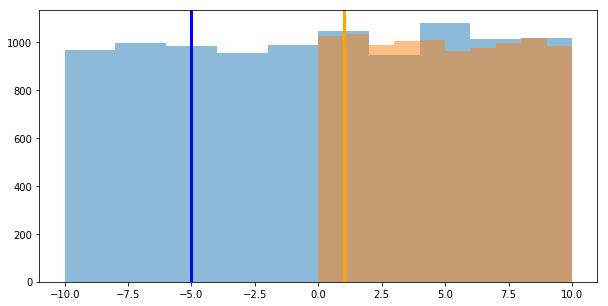

In [7]:
# visualize the prior parameter space
plt.figure(figsize=[10,5])
plt.hist(params[:,0], alpha = 0.5)
plt.hist(params[:,1], alpha = 0.5)
plt.axvline(theta_1_true, color="blue", lw=3)
plt.axvline(theta_2_true, color="orange", lw=3)

pass

## 2. Construct the summarized reference table

In [8]:
import pandas as pd
from tsfresh import extract_features
from tsfresh.feature_extraction.settings import EfficientFCParameters, MinimalFCParameters


In [9]:
y_pd = pd.DataFrame({"id":index, "time":time, "y":y_data})

In [32]:
regen = False
mini = False
if mini:
    default_fc_parameters = MinimalFCParameters()
else:
    default_fc_parameters = EfficientFCParameters()
if regen:
    y_data_ss = extract_features(y_pd, column_id="id", column_sort="time",
                                 default_fc_parameters=default_fc_parameters)
    y_data_ss.to_csv("../data/y_data.csv")
else:
    y_data_ss = pd.read_csv("../data/y_data.csv")

Feature Extraction: 100%|██████████| 20/20 [02:31<00:00,  4.83s/it]


## 3. Split data


In [33]:
from sklearn.model_selection import train_test_split

# clean the features!
import tsfresh.transformers.per_column_imputer as PCI
pci_trans = PCI.PerColumnImputer()
y_data_ss_pci = pci_trans.fit_transform(y_data_ss)

 'y__agg_linear_trend__f_agg_"max"__chunk_len_10__attr_"rvalue"'
 'y__agg_linear_trend__f_agg_"max"__chunk_len_10__attr_"slope"'
 'y__agg_linear_trend__f_agg_"max"__chunk_len_10__attr_"stderr"'
 'y__agg_linear_trend__f_agg_"max"__chunk_len_50__attr_"intercept"'
 'y__agg_linear_trend__f_agg_"max"__chunk_len_50__attr_"rvalue"'
 'y__agg_linear_trend__f_agg_"max"__chunk_len_50__attr_"slope"'
 'y__agg_linear_trend__f_agg_"max"__chunk_len_50__attr_"stderr"'
 'y__agg_linear_trend__f_agg_"mean"__chunk_len_10__attr_"intercept"'
 'y__agg_linear_trend__f_agg_"mean"__chunk_len_10__attr_"rvalue"'
 'y__agg_linear_trend__f_agg_"mean"__chunk_len_10__attr_"slope"'
 'y__agg_linear_trend__f_agg_"mean"__chunk_len_10__attr_"stderr"'
 'y__agg_linear_trend__f_agg_"mean"__chunk_len_50__attr_"intercept"'
 'y__agg_linear_trend__f_agg_"mean"__chunk_len_50__attr_"rvalue"'
 'y__agg_linear_trend__f_agg_"mean"__chunk_len_50__attr_"slope"'
 'y__agg_linear_trend__f_agg_"mean"__chunk_len_50__attr_"stderr"'
 'y__agg_lin

In [34]:
X_train_1, X_test_1, y_train_1, y_test_1 = train_test_split(y_data_ss_pci, params[:,0], test_size=0.3, random_state=0)
X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(y_data_ss_pci, params[:,1], test_size=0.3, random_state=0)

## 4. Fit data, RF

In [35]:
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor

In [46]:
# a) construct model
# b) fit model
# c) predict with model

#model_1 = CatBoostRegressor(random_state=0,
#                            logging_level="Silen")
model_1 = RandomForestRegressor(random_state=0, n_estimators=100)
model_1.fit(X_train_1,y_train_1)
theta_hat_1 = model_1.predict(X_test_1)


model_2 = RandomForestRegressor(random_state=0, n_estimators=100)
model_2.fit(X_train_2,y_train_2)
theta_hat_2 = model_2.predict(X_test_2)


In [65]:
def plotFI(N, feature_names, model):
    importances = model.feature_importances_
    #std = np.std([tree.feature_importances_ for tree in model_1.estimators_],
    #             axis=0)
    indices = np.argsort(importances)[::-1][:N]

    # Print the feature ranking
    #print("Feature ranking:")

    #for f in range(y_data_ss_pci.shape[1]):
    #    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

    # Plot the feature importances of the forest
    plt.figure(figsize=[10,20])
    plt.title("Feature importances")
    plt.barh(feature_names[indices], importances[indices],
           color="r", align="center")
    #plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
    #plt.yticks(feature_names[indices])
    #plt.xlim([-1, y_data_ss_pci.shape[1]])
    plt.show()

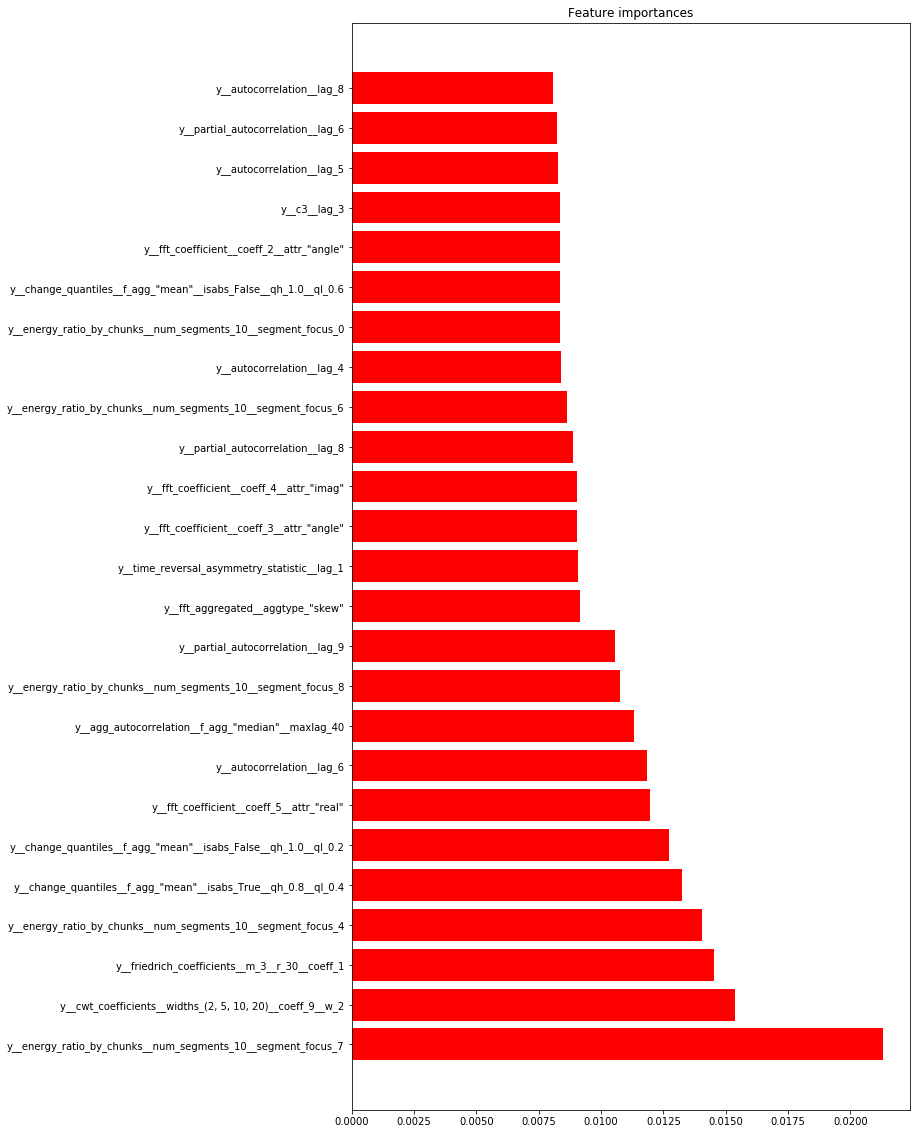

In [66]:
plotFI(25,y_data_ss.columns, model_1)

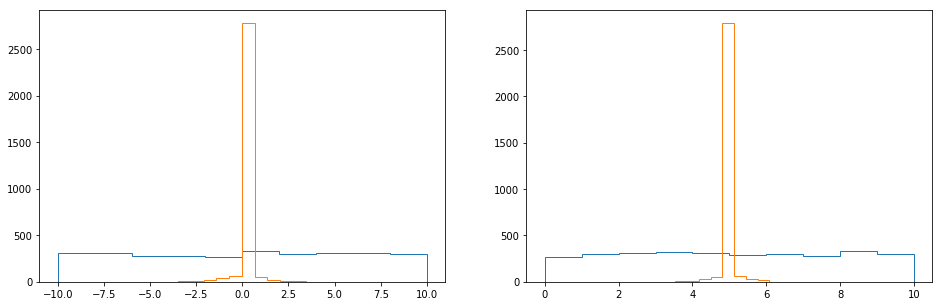

In [67]:
plt.figure(figsize=[16,5])
plt.subplot(1,2,1)
plt.hist(y_test_1, density=False, histtype="step")
plt.hist(theta_hat_1, density=False, histtype="step")

plt.subplot(1,2,2)
plt.hist(y_test_2, density=False, histtype="step")
plt.hist(theta_hat_2, density=False, histtype="step")
pass

## Can we infe the parameters on the observation?

In [52]:
obs_pd = pd.DataFrame({"id":np.repeat(0,size_y), "time":range(size_y), "y":y_obs})
obs_ss = extract_features(obs_pd, column_id="id", column_sort="time",
                          default_fc_parameters = default_fc_parameters)
obs_ss_pci = pci_trans.transform(obs_ss)

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00, 10.58it/s]


In [53]:
theta_1_infer = model_1.predict(obs_ss_pci)[0]
theta_2_infer = model_2.predict(obs_ss_pci)[0]

print("true:", [theta_1_true, theta_2_true])
print("infered:", [theta_1_infer, theta_2_infer])

true: [-5, 1]
infered: [-0.07563226081640168, 5.789556691100006]
